In [1]:
import sys
sys.path.append('../code/functions')
sys.path.append('/home/simpleElastix/build/SimpleITK-build/Wrapping/Python')

import pickle

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from tiffIO import loadTiff, unzipChannels
from connectLib import otsuVox


# Load Data

In [2]:
tp1ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp1.tif'))

In [3]:
tp2ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp2.tif'))

In [4]:
print tp1ChanList.shape
print tp2ChanList.shape

(2, 280, 1024, 1024)
(2, 280, 1024, 1024)


In [5]:
tp1Test = tp1ChanList[1][:10]
tp2Test = tp2ChanList[1][:10]

In [6]:
print tp1Test.shape
print tp2Test.shape

(10, 1024, 1024)
(10, 1024, 1024)


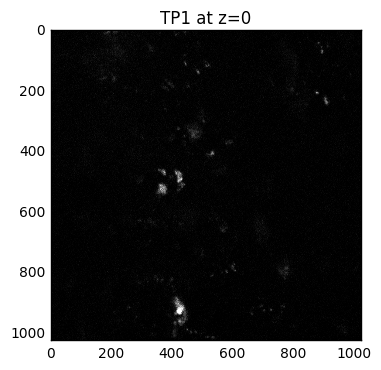

In [7]:
fig = plt.figure()
plt.imshow(tp1Test[0], cmap='gray')
plt.title('TP1 at z=0')
plt.show()

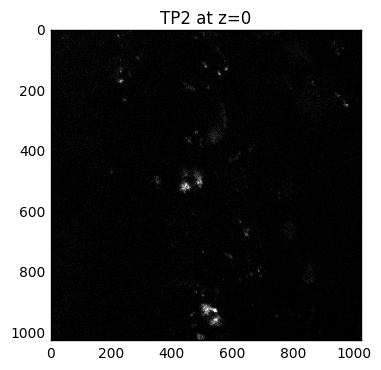

In [8]:
fig = plt.figure()
plt.imshow(tp2Test[0], cmap='gray')
plt.title('TP2 at z=0')
plt.show()

# Visualization Functions

In [9]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()

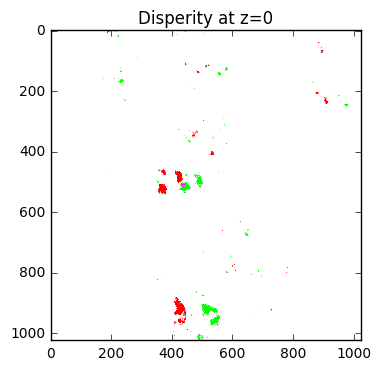

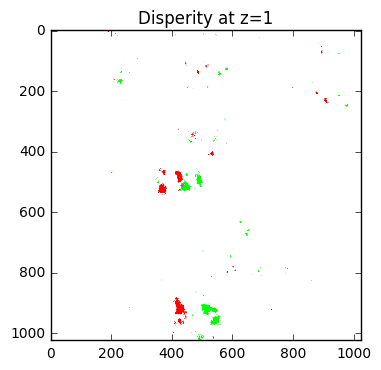

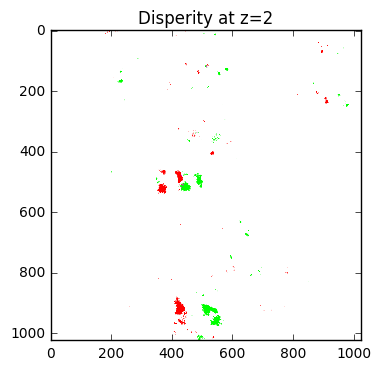

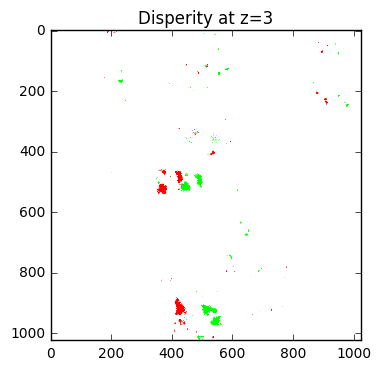

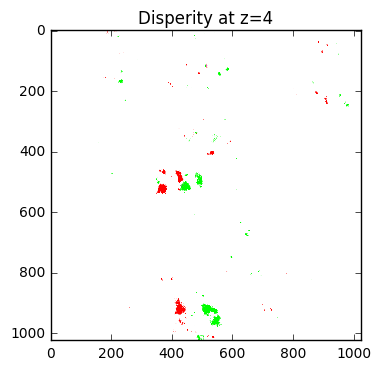

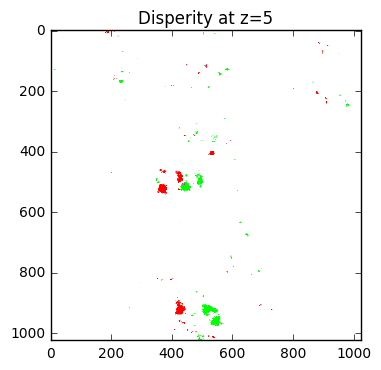

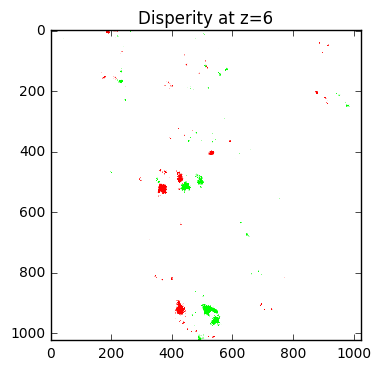

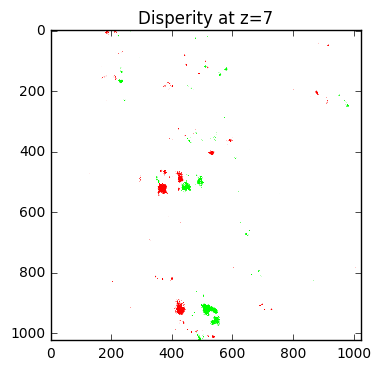

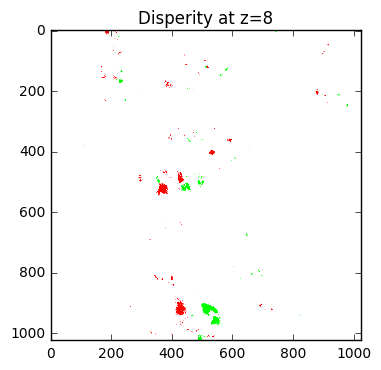

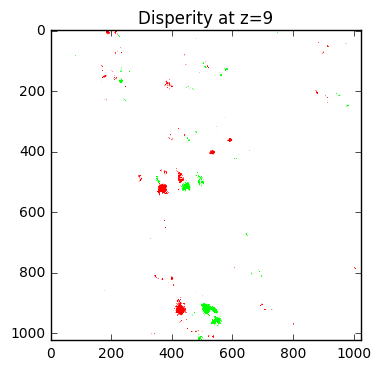

In [10]:
visVolDiff(otsuVox(tp1Test), otsuVox(tp2Test))

In [18]:
arraySeries = [sitk.GetImageFromArray(np.array(tp1Test, dtype='float32'), isVector=False),
               sitk.GetImageFromArray(np.array(tp2Test, dtype='float32'), isVector=False)]

imgVector = sitk.VectorOfImage()
imgVector.push_back(arraySeries[0])
imgVector.push_back(arraySeries[1])
imgSeries = sitk.JoinSeries(imgVector)

In [34]:
SimpleElastix = sitk.SimpleElastix()
SimpleElastix.LogToConsoleOn()
SimpleElastix.SetFixedImage(arraySeries[0])
SimpleElastix.SetMovingImage(arraySeries[1])
params = sitk.VectorOfParameterMap()
params.append(sitk.GetDefaultParameterMap('bspline'))
SimpleElastix.SetParameterMap(params)
SimpleElastix.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fcecb857780> >

In [35]:
result = SimpleElastix.GetResultImage()

In [36]:
arrayResult = sitk.GetArrayFromImage(result)

In [37]:
arrayResult.shape

(10, 1024, 1024)

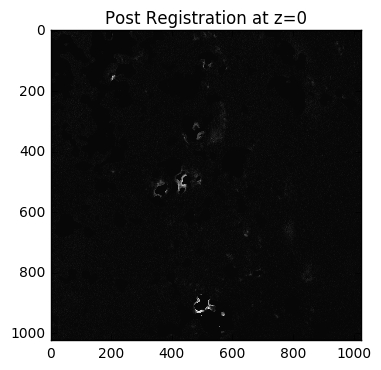

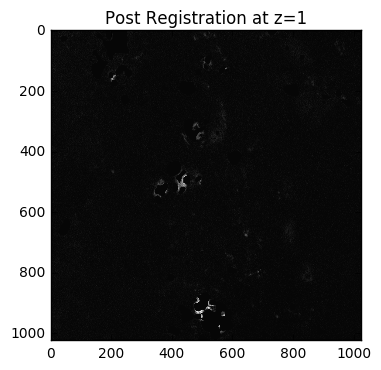

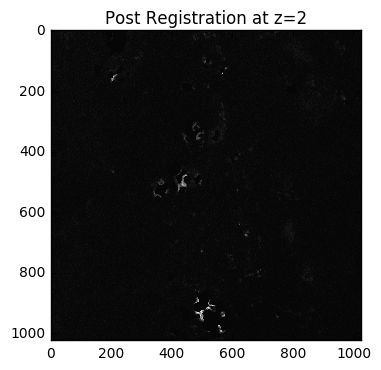

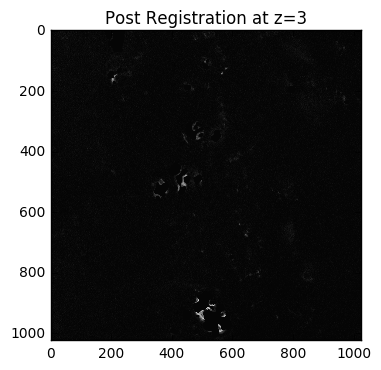

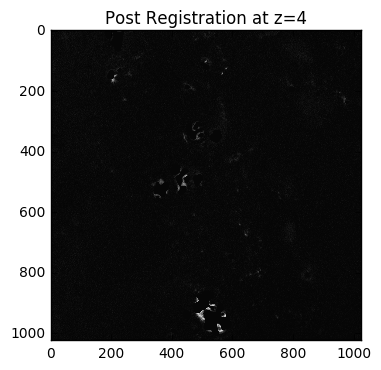

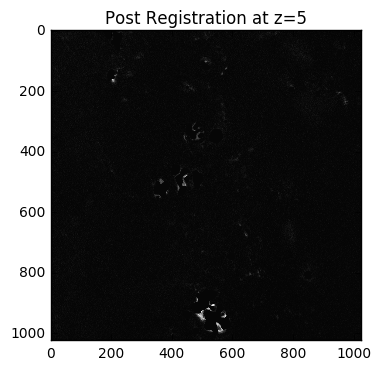

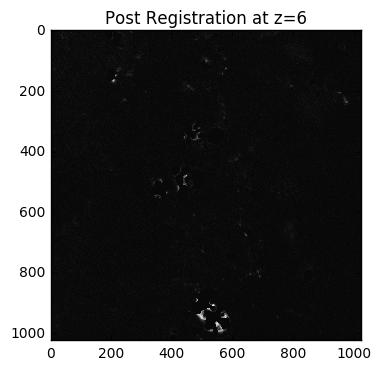

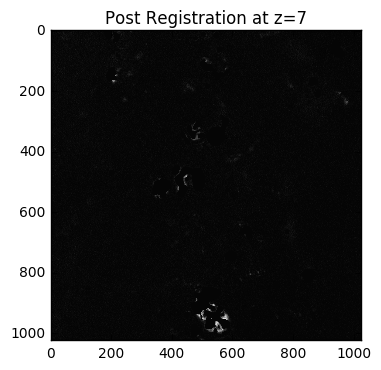

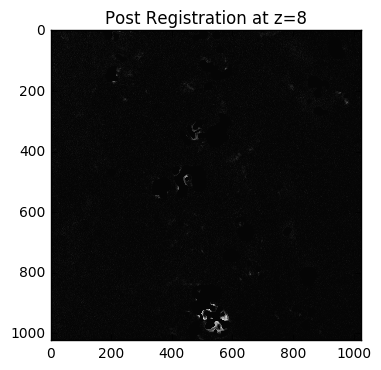

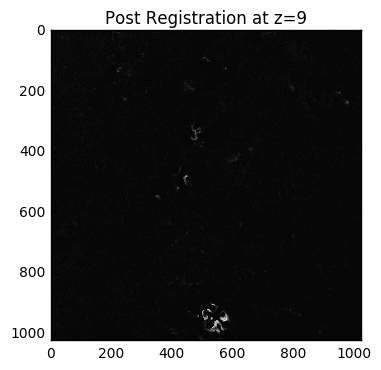

In [38]:
for z, elem in enumerate(arrayResult):
    fig = plt.figure()
    plt.title('Post Registration at z='+str(z))
    plt.imshow(elem, cmap='gray')
    plt.show()